Clean Text and Categorical Columns

## Data Cleaning: Handle Missing Values, Remove Duplicates, Address Outliers
This section demonstrates how to handle missing values, remove duplicates, and address outliers in your dataset.

In [10]:
import sys
sys.path.append('../src')
import importlib
import data_preprocessing
import pandas as pd
DATA_PATH = '../data/processed/amazon.csv'
df = pd.read_csv(DATA_PATH)

importlib.reload(data_preprocessing)

if hasattr(data_preprocessing, 'clean_chunk'):
    df_clean = data_preprocessing.clean_chunk(df)
    display(df_clean.head())
else:
    print("clean_chunk is still not found in data_preprocessing.py. Please check the file for typos or indentation errors.")


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329.0,699.0,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154.0,399.0,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [11]:
# Save the cleaned data to processed directory
cleaned_path = '../data/processed/amazon_clean.csv'
df_clean.to_csv(cleaned_path, index=False)
print(f"Cleaned data saved to '{cleaned_path}'")

Cleaned data saved to '../data/processed/amazon_clean.csv'


Address outliers, discussed here

# Exploratory Data Analysis (EDA)
This section covers:
- Univariate analysis (distributions)
- Bivariate analysis (relationships)
- Correlation analysis


Descriptive Statistics for 'discounted_price':
count     1465.000000
mean      3125.310874
std       6944.304394
min         39.000000
25%        325.000000
50%        799.000000
75%       1999.000000
max      77990.000000


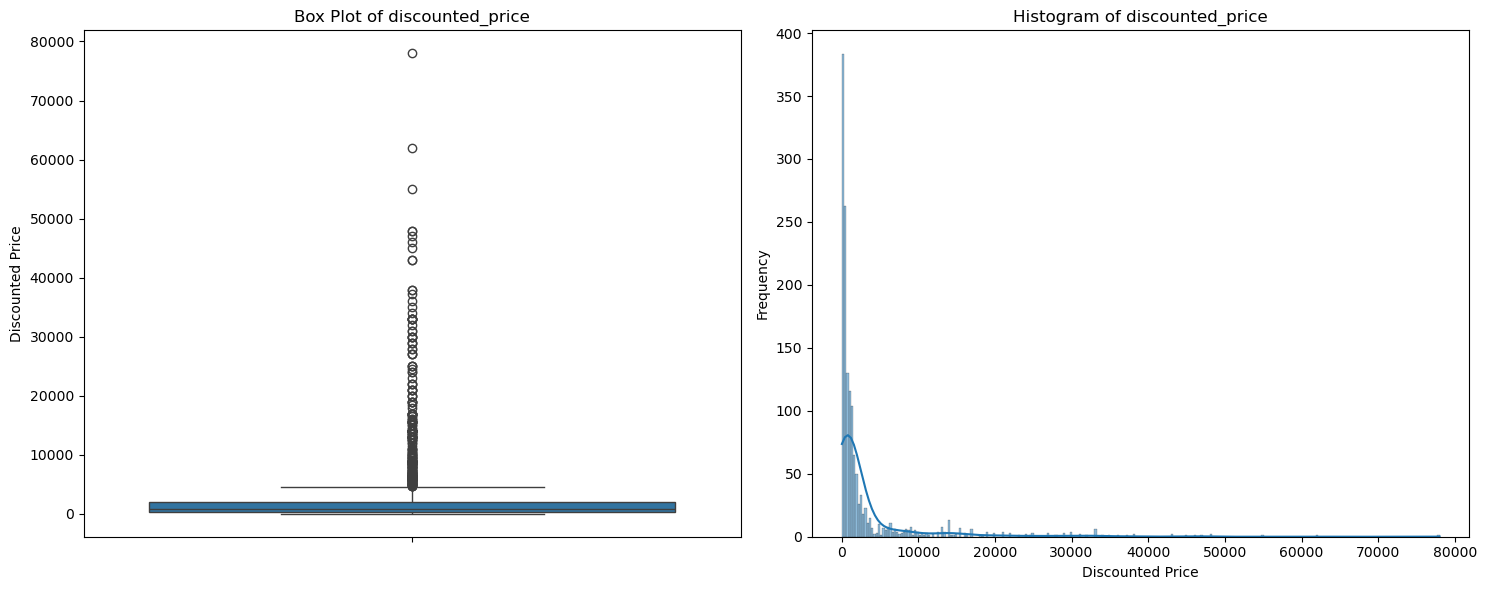


Descriptive Statistics for 'actual_price':
count      1465.000000
mean       5444.990635
std       10874.826864
min          39.000000
25%         800.000000
50%        1650.000000
75%        4295.000000
max      139900.000000


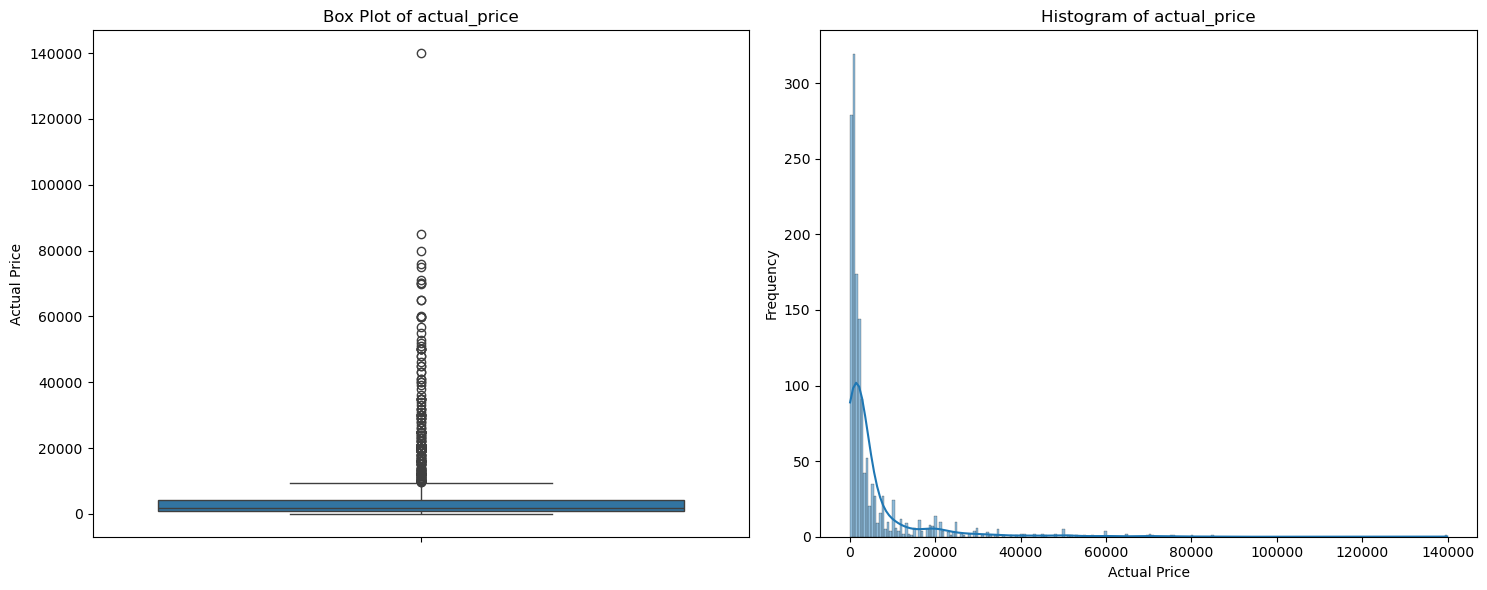


Descriptive Statistics for 'discount_percentage':
count    1465.000000
mean       47.691468
std        21.635905
min         0.000000
25%        32.000000
50%        50.000000
75%        63.000000
max        94.000000


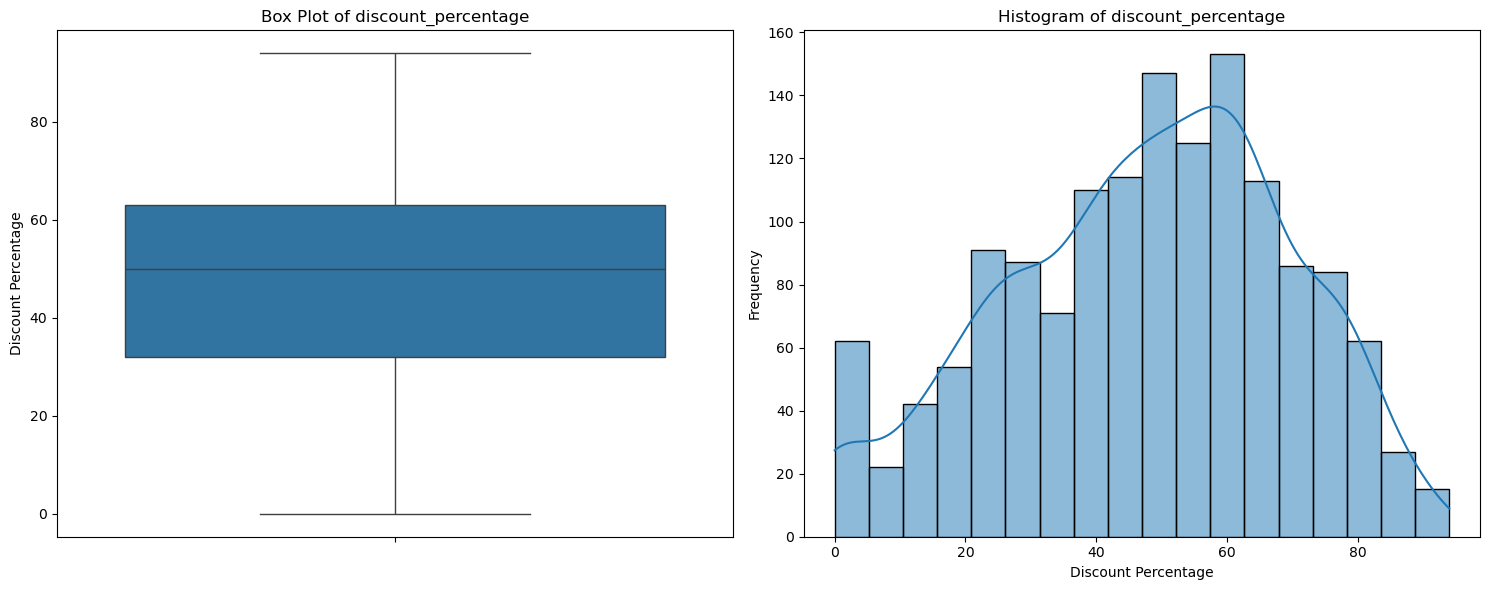


Descriptive Statistics for 'rating':
count    1464.000000
mean        4.096585
std         0.291674
min         2.000000
25%         4.000000
50%         4.100000
75%         4.300000
max         5.000000


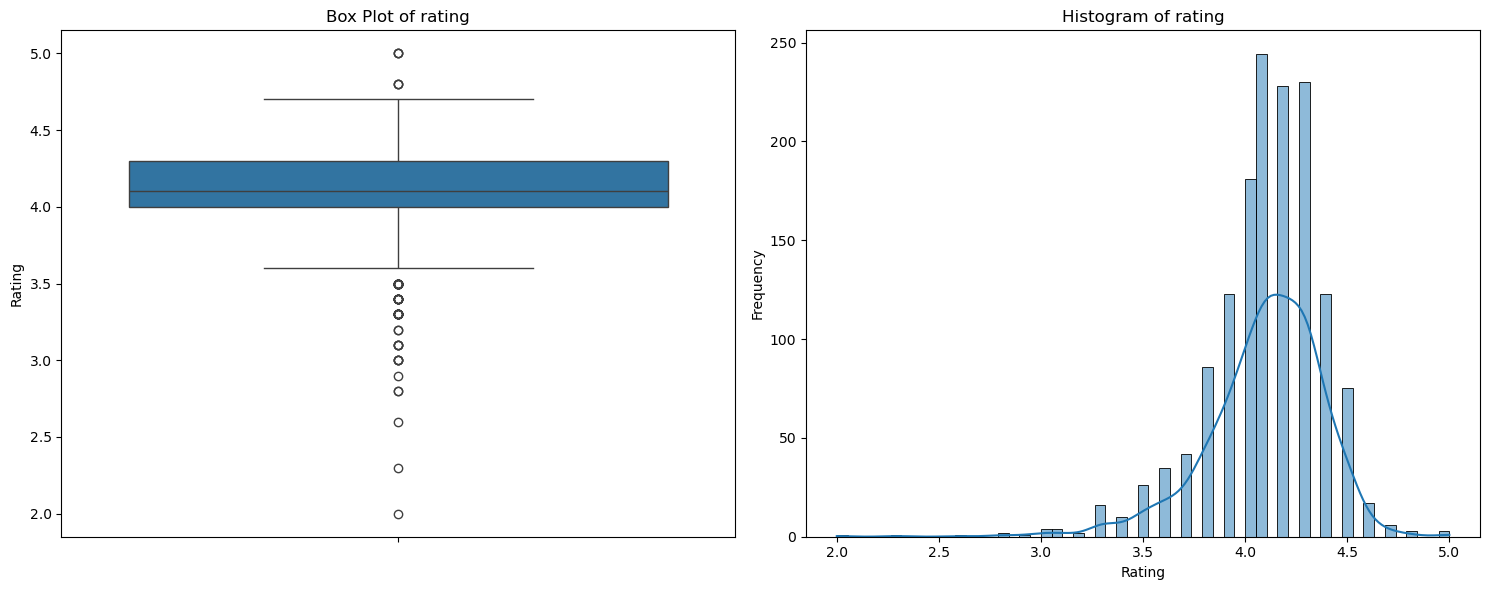


Descriptive Statistics for 'rating_count':
count      1465
unique     1143
top       9,378
freq         11


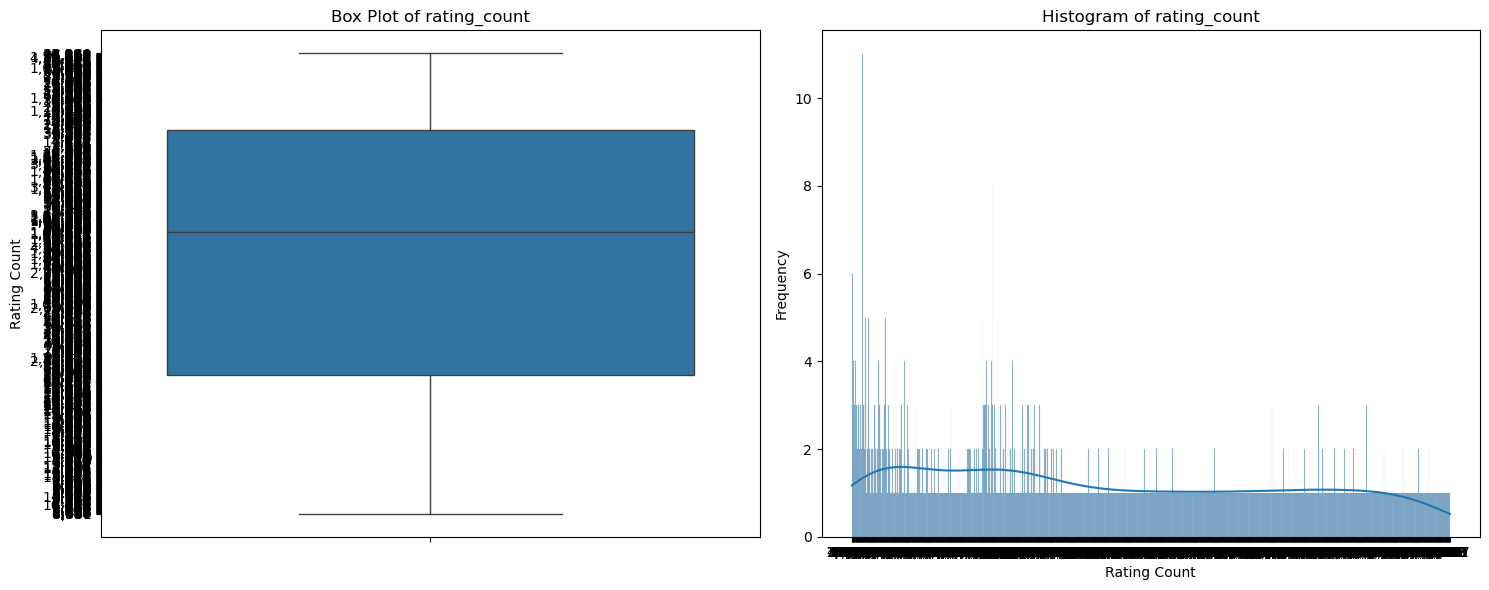

In [50]:
#Univariate Analysis of Numerical Columns
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']

for col in numerical_cols:
    print(f"\nDescriptive Statistics for '{col}':")
    print(df[col].describe().to_string())

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Box Plot
    sns.boxplot(y=df[col], ax=axes[0])
    axes[0].set_title(f'Box Plot of {col}')
    axes[0].set_ylabel(col.replace('_', ' ').title())

    # Histogram with KDE
    sns.histplot(df[col], kde=True, ax=axes[1])
    axes[1].set_title(f'Histogram of {col}')
    axes[1].set_xlabel(col.replace('_', ' ').title())
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


Interpretation: These box plots are used to identify outliers and understand the interquartile range (IQR). For prices and rating counts, these plots likely show a "heavy-tail" with many extreme values (outliers) on the higher end.
These show the shape of the data distribution. The rating_count and price features show a strong right-skew (the "Long-Tail"), meaning most products are affordable and have few reviews, while a small "head" of products are expensive or viral. The rating histogram typically shows a concentration around the 4.0–4.5 range.

Top 20 Product Categories and their Frequencies:
category
Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables                        233
Electronics|WearableTechnology|SmartWatches                                                               76
Electronics|Mobiles&Accessories|Smartphones&BasicMobiles|Smartphones                                      68
Electronics|HomeTheater,TV&Video|Televisions|SmartTelevisions                                             63
Electronics|Headphones,Earbuds&Accessories|Headphones|In-Ear                                              52
Electronics|HomeTheater,TV&Video|Accessories|RemoteControls                                               49
Home&Kitchen|Kitchen&HomeAppliances|SmallKitchenAppliances|MixerGrinders                                  27
Electronics|HomeTheater,TV&Video|Accessories|Cables|HDMICables                                            24
Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cleaning&Ironing|Irons,Stea

/var/folders/60/ksk2php90gg8y49d13k6swkh0000gn/T/ipykernel_24518/990773400.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')
/var/folders/60/ksk2php90gg8y49d13k6swkh0000gn/T/ipykernel_24518/990773400.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout() # Adjust layout to prevent labels from overlapping


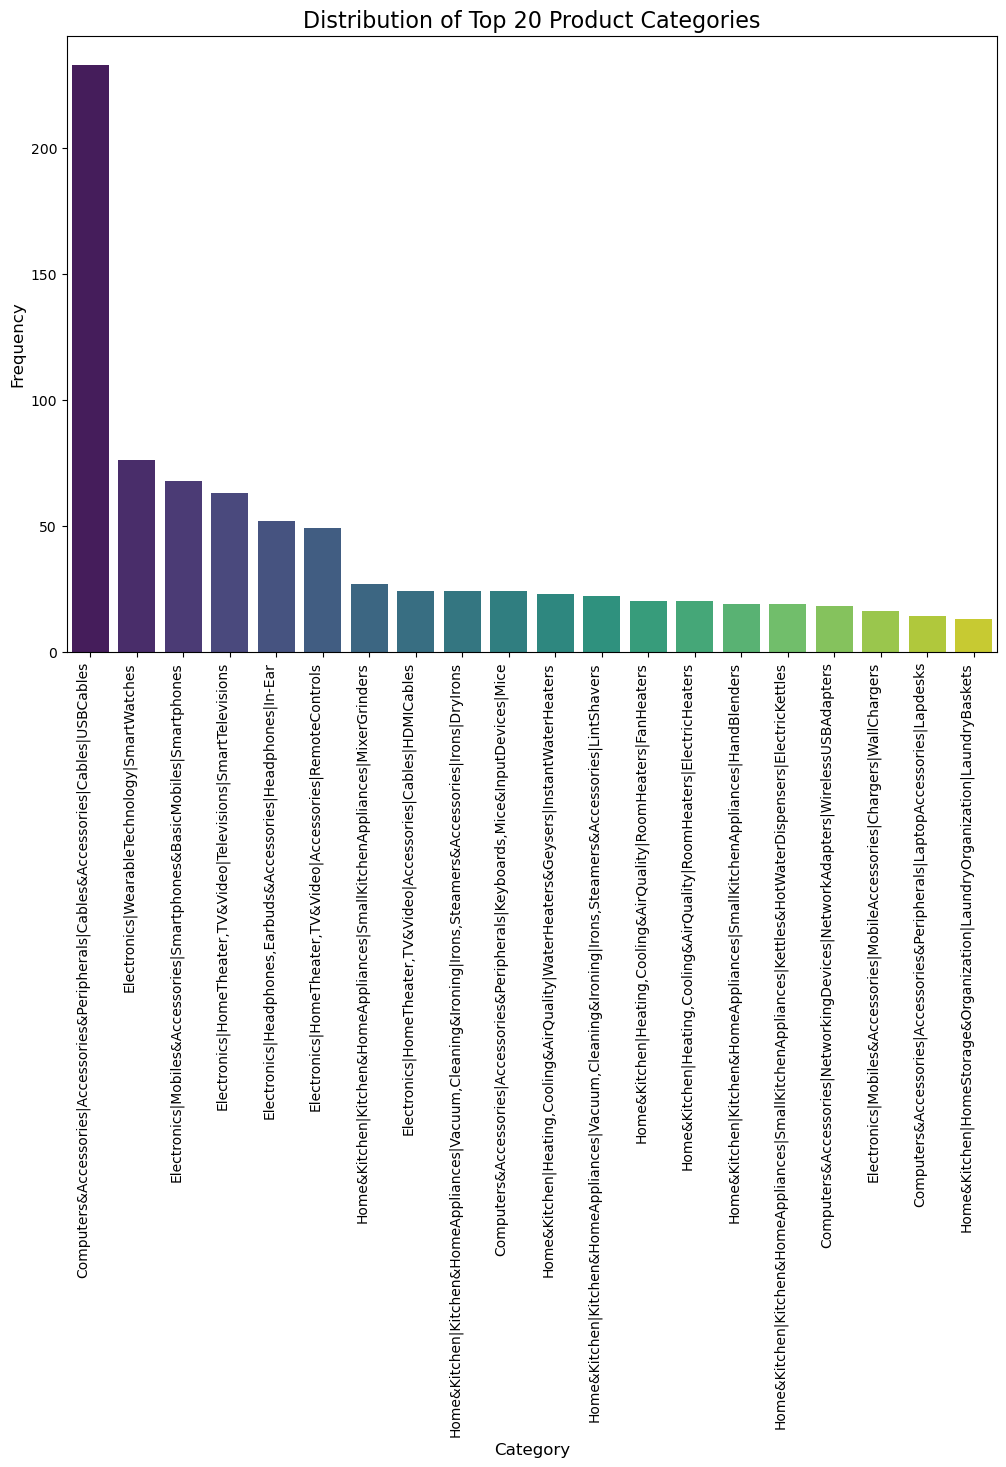

In [51]:
#Univariate Analysis of Categorical Columns
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate and print value counts for the 'category' column (top 20)
top_categories = df['category'].value_counts().head(20)
print("Top 20 Product Categories and their Frequencies:")
print(top_categories.to_string())

# 2. Create a bar plot to visualize the distribution of the top 20 product categories
plt.figure(figsize=(12, 8))
sns.barplot(x=top_categories.index, y=top_categories.values, palette='viridis')

# 3. Ensure the plot has a title, appropriate x and y labels, and rotate x-axis labels
plt.title('Distribution of Top 20 Product Categories', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=90, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# 4. Display the plot
plt.show()

Interpretation, this chart visualizes the frequency of the top 20 product categories in the Amazon dataset. It highlights Categorical Dominance. By identifying that certain categories (like "USB Cables" or "Electronics") appear more frequently, we need to highlight this finding that we  need in our recommendation engine needs to be "surgical" in those areas to help users distinguish between many similar items, not only in this heavy dominated products in the top category.

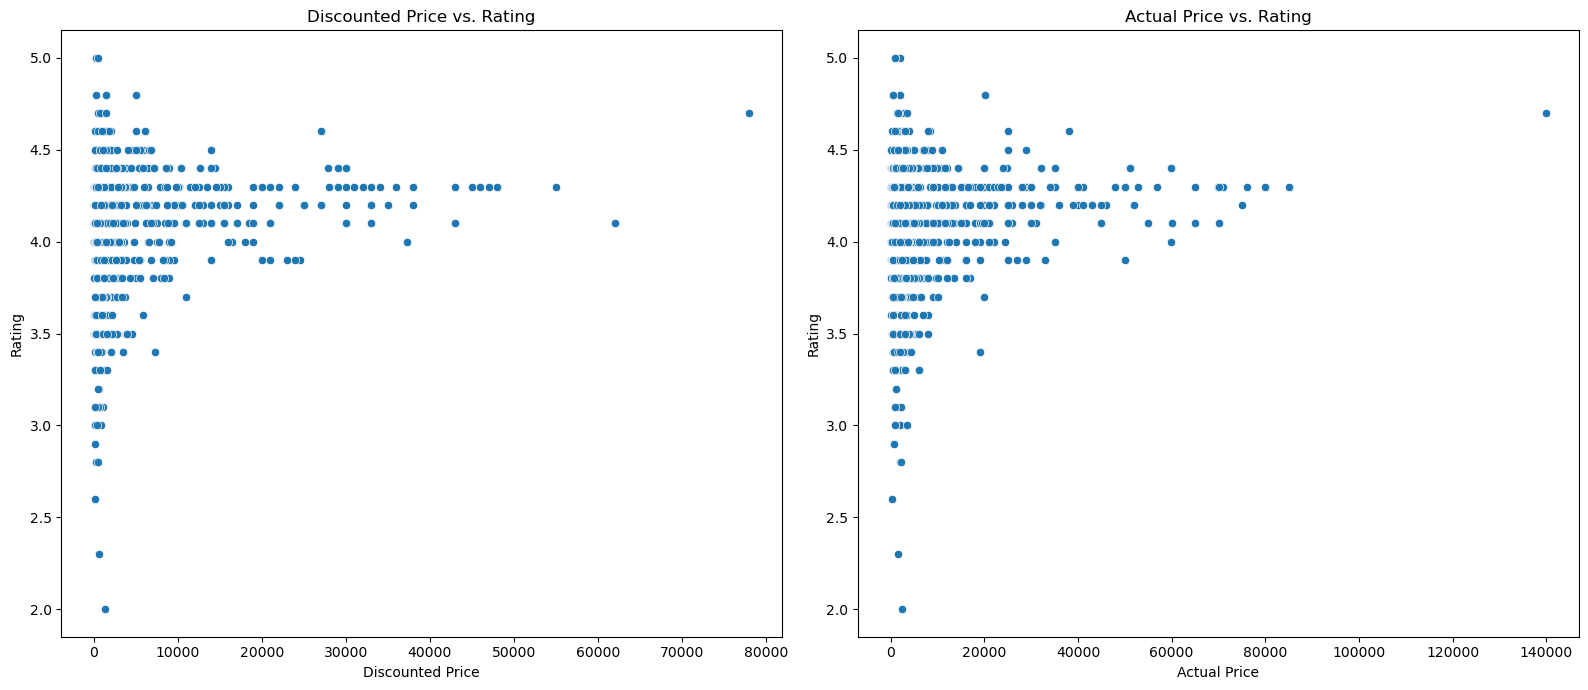

In [52]:
#Bivariate Analysis: Price vs. Rating
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Discounted Price vs. Rating
sns.scatterplot(x=df['discounted_price'], y=df['rating'], ax=axes[0])
axes[0].set_title('Discounted Price vs. Rating')
axes[0].set_xlabel('Discounted Price')
axes[0].set_ylabel('Rating')

# Plot 2: Actual Price vs. Rating
sns.scatterplot(x=df['actual_price'], y=df['rating'], ax=axes[1])
axes[1].set_title('Actual Price vs. Rating')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Rating')

plt.tight_layout()
plt.show()

These plots explore the relationship between the cost of an item and its customer satisfaction.
This visualization supports our finding of the "Price/Quality Paradox." The scattered nature of the points (with no clear linear trend) proves that a higher price does not necessarily guarantee a higher rating, suggesting that factors other than price (like technical specs or brand trust) drive satisfaction.

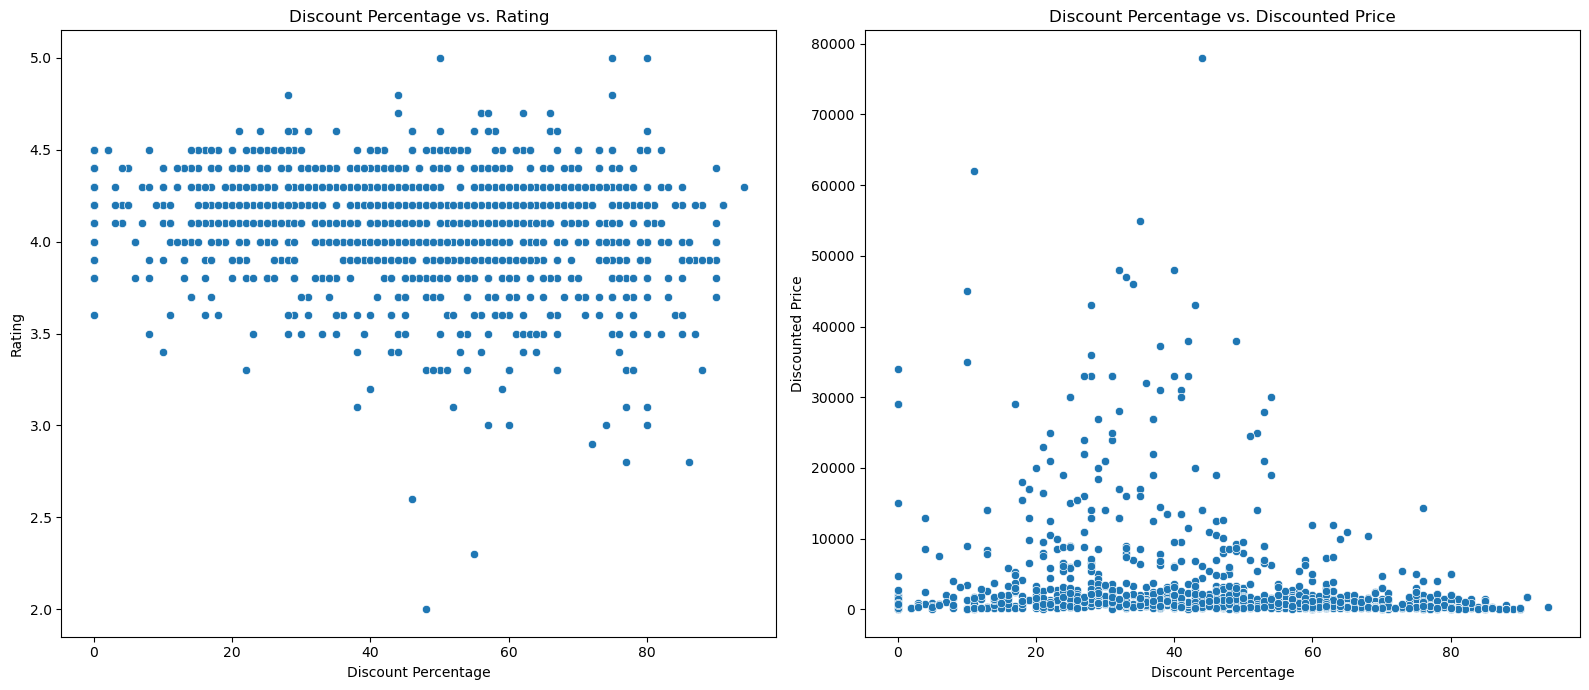

In [53]:
#Bivariate Analysis: Discount vs. Rating/Price
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Discount Percentage vs. Rating
sns.scatterplot(x=df['discount_percentage'], y=df['rating'], ax=axes[0])
axes[0].set_title('Discount Percentage vs. Rating')
axes[0].set_xlabel('Discount Percentage')
axes[0].set_ylabel('Rating')

# Plot 2: Discount Percentage vs. Discounted Price
sns.scatterplot(x=df['discount_percentage'], y=df['discounted_price'], ax=axes[1])
axes[1].set_title('Discount Percentage vs. Discounted Price')
axes[1].set_xlabel('Discount Percentage')
axes[1].set_ylabel('Discounted Price')

plt.tight_layout()
plt.show()

Discount % vs. Rating: Checks if heavily discounted items receive poorer reviews.
Discount % vs. Discounted Price: Visualizes the pricing strategy (e.g., are expensive items the ones getting the 50%+ discounts?).
This helps determine if "bargain hunters" are as satisfied as full-price buyers, this might be critical for the Ethics and Fairness considerations.

Data types of selected columns before correlation:
discounted_price       float64
actual_price           float64
discount_percentage      int64
rating                 float64
rating_count           float64

Correlation Matrix:
                     discounted_price  actual_price  discount_percentage    rating  rating_count
discounted_price             1.000000      0.961915            -0.242412  0.120335     -0.078915
actual_price                 0.961915      1.000000            -0.118098  0.121636     -0.067518
discount_percentage         -0.242412     -0.118098             1.000000 -0.155273      0.093422
rating                       0.120335      0.121636            -0.155273  1.000000     -0.101895
rating_count                -0.078915     -0.067518             0.093422 -0.101895      1.000000


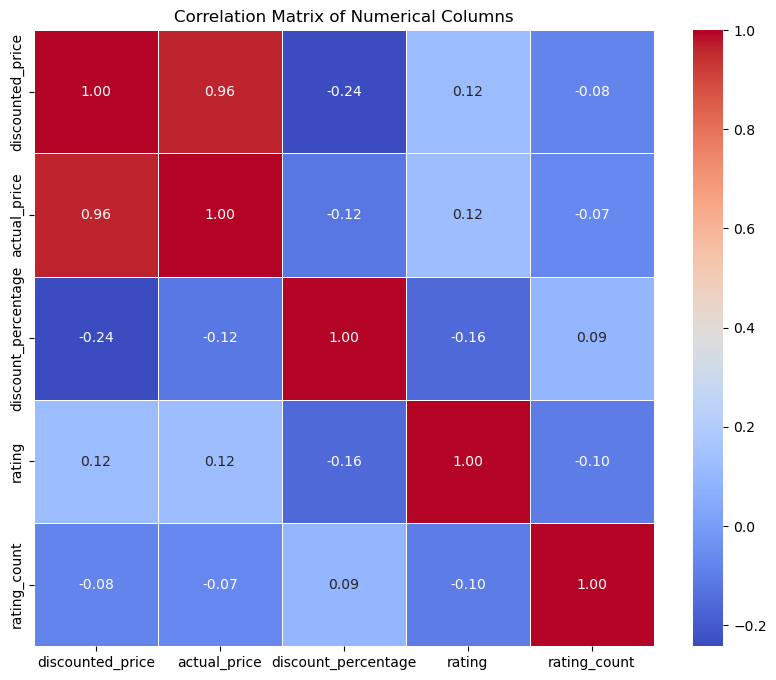

In [54]:
#Correlation Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Select the relevant numerical columns
correlation_cols = ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']
selected_df = df[correlation_cols].copy() # Use .copy() to ensure we're working on a separate DataFrame

# Ensure all selected columns are numeric and handle any potential remaining non-numeric values
for col in correlation_cols:
    # Convert to numeric, coercing errors will turn non-convertible values into NaN
    selected_df[col] = pd.to_numeric(selected_df[col], errors='coerce')
    
    # Fill any NaNs that might have been introduced by 'coerce' or existed previously
    if col == 'rating_count':
        selected_df[col] = selected_df[col].fillna(0)
    elif col == 'rating':
        selected_df[col] = selected_df[col].fillna(selected_df[col].median())
    else: # For price and percentage columns
        selected_df[col] = selected_df[col].fillna(selected_df[col].mean())

print("Data types of selected columns before correlation:")
print(selected_df.dtypes.to_string())

# Calculate the correlation matrix
correlation_matrix = selected_df.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.to_string())

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

This provides a bird's-eye view of the mathematical relationships between all numerical features.
It highlights strong positive correlations (e.g., between actual_price and discounted_price).
It reveals "Near-Zero" correlations (e.g., between discount_percentage and rating),reinforcing the idea that discounts don't negatively impact perceived quality, thus, we can't see relation on "best rated" are the "lowest price".


Final Narrative: From Data Patterns to Product Discovery
This EDA serves as the foundational narrative of our dataset, it allows us to see the underlying patterns that will power our primary objective: the product recommendation engine. By unfolding the story hidden within the raw Amazon metadata, we have moved beyond simple assumptions and decoded the true "statistical DNA" of our catalog.
The Story of Our Features:
The Price/Quality Paradox: Our bivariate and correlation analyses revealed a crucial "plot twist": customer satisfaction is independent of price. High-priced items do not guarantee better ratings, nor do deep discounts automatically drive higher satisfaction.
The Popularity Surge: The heavy right-skew in rating_count identifies our "protagonists"—the viral, high-engagement products that define the market focus of the dataset.
Categorical Dominance: The clear dominance of the USB Cables segment tells us exactly where our engine needs to be the most "surgical," using NLP to differentiate between hundreds of similar items.

	As we have discovered that pricing and ratings are disconnected, our product recommendation engine model cannot rely on a basic sorting logic or category search. Instead, this narrative leads us directly to our Multi-Stage Hybrid Architecture, where Natural Language Processing (NLP) bridges the gap between what a product costs and why a user loves it (reviews).

To further prove our point above we will check Multi-Expert Intent Discovery (The Behavioral vs. Content Gap)

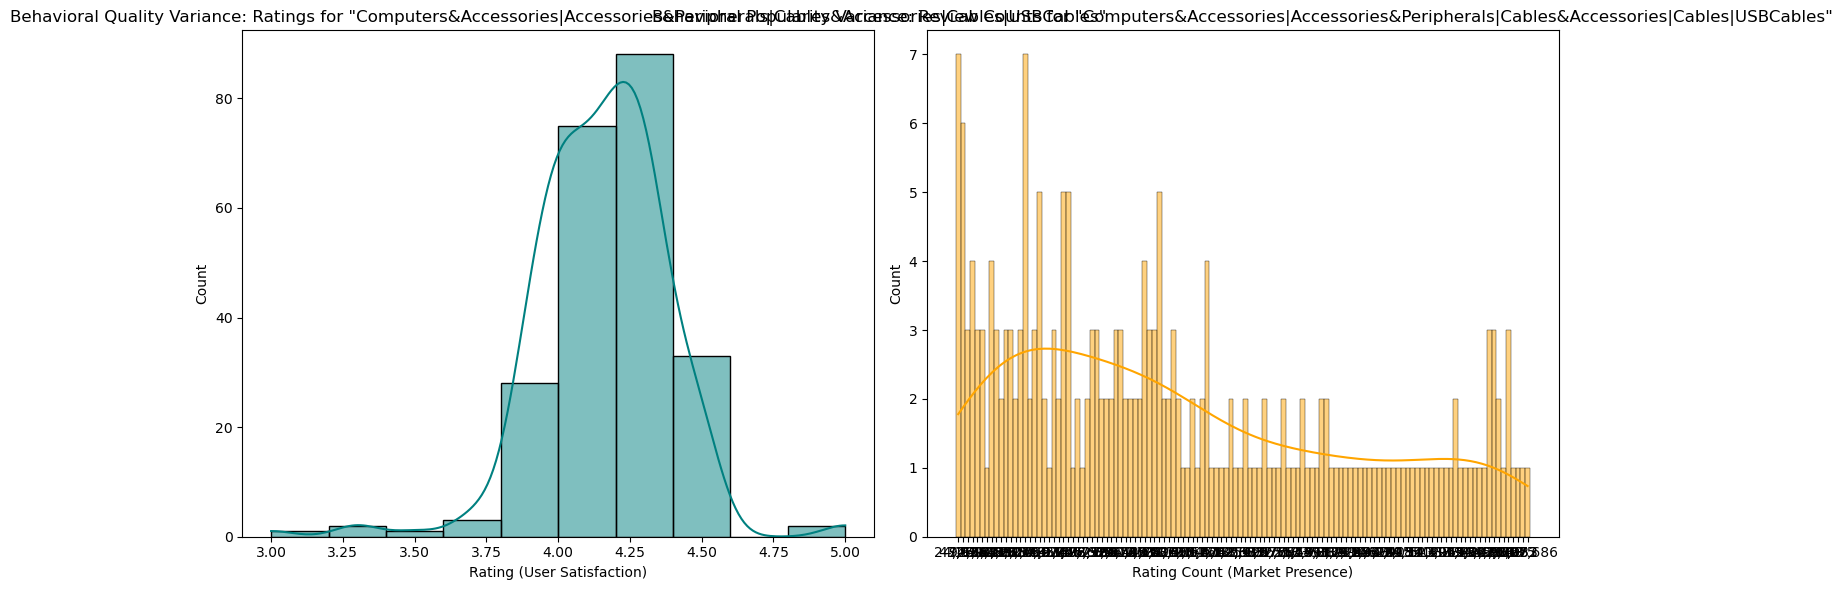

Analysis for Category: Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables
Mean Rating: 4.15
Standard Deviation of Rating: 0.23


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select a dominant category to inspect (The "Surgical" Category identified in Cell 11)
target_category = df['category'].value_counts().idxmax()
category_subset = df[df['category'] == target_category]

# 2. Visualize Behavioral Variance within a single Content Group
plt.figure(figsize=(14, 6))

# Subplot 1: Distribution of Ratings within the SAME category
plt.subplot(1, 2, 1)
sns.histplot(category_subset['rating'], bins=10, kde=True, color='teal')
plt.title(f'Behavioral Quality Variance: Ratings for "{target_category}"')
plt.xlabel('Rating (User Satisfaction)')

# Subplot 2: Distribution of Popularity within the SAME category
plt.subplot(1, 2, 2)
sns.histplot(category_subset['rating_count'], bins=20, kde=True, color='orange')
plt.title(f'Behavioral Popularity Variance: Review Counts for "{target_category}"')
plt.xlabel('Rating Count (Market Presence)')

plt.tight_layout()
plt.show()

# 3. Correlation between Category Frequency and Quality
print(f"Analysis for Category: {target_category}")
print(f"Mean Rating: {category_subset['rating'].mean():.2f}")
print(f"Standard Deviation of Rating: {category_subset['rating'].std():.2f}")

The resul shows first off the numbers, Standard Deviation of Rating: 0.23 - proves that user satisfaction is not uniform. While the average is 4.15, there is a significant spread. Some cables are likely underperforming near 3.7 while others are elite near 4.6. Every product in this subset belongs to the exact same category:Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables


 The "Gap" refers to the fact that what a product is (its description, category, and specs) does not always match how people react to it (its ratings, popularity, and reviews).

If we rely on content: If a user searches for "USB Cable," the Content Expert identifies all 1,000 cables in the database, we will miss those scenarios that what if user's only wants the one that won't break in a week, which is behavioral.

What we have proved is that a single-model approach would treat all cables as equal, so we must navigate this 0.23 variance ensuring the user isn't just shown 'a cable,' but 'the best cable' according to the market consensus


